In [4]:
import phylopandas as ph
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA

# new_sseeq = ph.read_fasta('data/GISAID/newfile.fasta') #original dataset covid-19
new_seq = ph.read_fasta('data/GISAID/sequences.fasta') #covid-19 data (600 sequences) as of 3/17/20
new_seq = new_seq.drop(columns = ['label','uid','description']) #dropping redundant attributes 
new_metadata = pd.read_csv('data/GISAID/metadata.tsv', sep = '\t')
# (These  datasets were downloaded from GISAID https://www.gisaid.org and #https://github.com/nextstrain/ncov, respectively.


old_seq = ph.read_fasta('old_data/Coronaviridae_old.fasta') #other coronaviruses
old_info = pd.read_csv('old_data/Coronaviridae_old_information_table.txt', sep = '\t')
# (These two datasets were downloaded from Virus-Host DB https://www.genome.jp/virushostdb/).


FileNotFoundError: [Errno 2] No such file or directory: 'smaller_data/GISAID/sequences.fasta'

Text(0,0.5,'Frequency in Data')

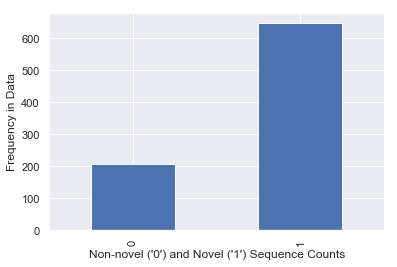

In [15]:
corona_df = pd.DataFrame(new_seq['sequence'])
corona_df['virus'] = 1 #1 for ncovid

other_df = pd.DataFrame(old_seq['sequence'])
other_df['virus'] = old_info['Virus lineage']

binary_df = pd.concat([corona_df,other_df])

binary_df['virus'][binary_df['virus'] != 1] = 0 #we will only need sequences to differentiate these viruses.
ax = binary_df['virus'].value_counts().sort_index().plot.bar()
ax.set_xlabel('Non-novel (\'0\') and Novel (\'1\') Sequence Counts')
ax.set_ylabel('Frequency in Data')

In [28]:
binary_df

,sequence,virus
0,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...,1
1,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...,1
2,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...,1
3,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...,1
4,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...,1
...,...,...
203,atttaagtgaatagcttggctatctcacttcccctcgttctcttgc...,0
204,acttttaaagtaaagtgagtgtagcgtggctatatctcttctttta...,0
205,gattaaagagaatagcatagctatccctctctctccgttctcttgt...,0
206,gactaaagataaaaattatagcattagtctataattttatctccct...,0


In [3]:
#get all kmers fpr one genetic sequence.
def get_Kmers_one_seq(seq, k):
    """gets all overlapping k-mers of a given sequence"""
    return [seq[x:x+k].lower() for x in range(len(seq) - k + 1)]

def get_Kmers_all_seqs(sequences, k):
    """get k-mers for a series of sequences"""
    kmers = np.zeros_like(sequences)
    for i,s in enumerate(sequences):
        kmers[i] = ' '.join(get_Kmers_one_seq(s, k))
    return list(kmers)

def get_kmers_df(X_df,k):
    """get a dataframe of k-mers associated with a sequence dataframe"""
    seq_kmers = get_Kmers_all_seqs(X_df['sequence'],k) # k-mer "sentences" generated, one per sequence. Formatted as such to impute into sklearn count vectorizer.
    kmer_df = pd.DataFrame(seq_kmers)
    kmer_df.columns = ['kmers']
    return kmer_df

In [4]:
get_Kmers_one_seq('AATTC',2) #example

['aa', 'at', 'tt', 'tc']

In [5]:
get_Kmers_all_seqs(['aattccg','ttccagggtta'],3) #example

['aat att ttc', 'ttc tcc cca']

In [ ]:
# Unused k-mer counting code. Slower implementation than sci-kit learn.

import itertools

def kmers_to_counts(one_seq):

    k_mers_by_char = list(itertools.combinations_with_replacement(alphb, k))

    unique_k_mers = []
    for i in k_mers_by_char:
        unique_k_mers.append(''.join(i))

    kmers_to_counts = dict(zip(unique_kmers,np.zeros_like(unique_k_mers)))

    for kmer in kmers_to_counts.keys():
        new_count = sum(1 for i in range(len(data)) if data.startswith(kmer, i))
        kmers_to_counts[kmer] = new_count

    return kmers_to_counts


def get_all_kmer_counts(seq_df):
    seq_df['kmer_to_count'] = [kmers_to_counts(seq) for seq in seq_df['sequence']]
    return seq_df



In [6]:
from sklearn.feature_extraction.text import CountVectorizer

def get_kmer_counts(kmer_df,k):
    cv = CountVectorizer(ngram_range=(k,k)) #k,k
    kmer_counts = cv.fit_transform(kmer_df['kmers'].values.astype('U')) #impute k-mers
    return kmer_counts #returns a sparse matrix



def pca_kmer_counts(kmer_counts_mtx,n_components = 2):
    """#PCA step: reduce dimensionality of data to 2 by default"""
    X = kmer_counts_mtx.toarray()
    pca = PCA(n_components = n_components)
    pca.fit_transform(X)
    X_reduced = pca.fit_transform(X)
    return X_reduced

In [8]:
k = 20
binary_df['kmers'] = get_kmers_df(binary_df,k)
X = get_kmer_counts(binary_df, k).toarray()
y = list(binary_df['virus'].astype(int))

In [29]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 3, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [10]:
#clustering step
#now have 2 dimensional dataset apt for plotting.
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
from sklearn.cluster import KMeans


def clust_preparation(clust_df,k): # adding to dataframe
    # clust_df['virus'][clust_df['virus'] != 1] = 0 #integer-labeling classs
    #get k-mers

    #get kmer counts for all sequences.
    
    kmers_df = get_kmers_df(clust_df,k) #getting kmers
    all_seq_kmercounts = get_kmer_counts(kmers_df, k)   #each row is a feature vector of kmer counts
    X_reduced_all = pca_kmer_counts(all_seq_kmercounts, 2)#reduce k-mer counts to 2 components (ideally, novel and non-novel coronavirus)

    return clust_df, X_reduced_all

def k_means_cluster(X_reduced_all):
    model = KMeans(n_clusters = 2)
    y_pred = model.fit_predict(X_reduced_all) #predict virus cluster
    centers = model.cluster_centers_
    return y_pred, centers
    
def plot_kmeans(X_reduced_all,y_pred,centers,k):
    plt.scatter(X_reduced_all[:,0],X_reduced_all[:,1], c = y_pred, s = 5, cmap = 'rainbow') #colored by label
    plt.scatter(centers[:,0], centers[:, 1], c='black', s=100, alpha=0.40)
    plt.title(f'2-means clustering, K=2 means, with K-mers of size {k}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')


In [11]:
# K-mer size of 20
clust_df20, X_reduced_all20 = clust_preparation(binary_df,20)

In [26]:
def plot_true(X_reduced_all,y_true,k_mersize):
    plt.scatter(X_reduced_all[:,0],X_reduced_all[:,1], c = y_true, s = 5, cmap = 'prism') #colored by label
    plt.title(f'PCA-reduced data, true labels, {k_mersize}-mers')
    plt.xlabel('PC1')
    plt.ylabel('PC2')

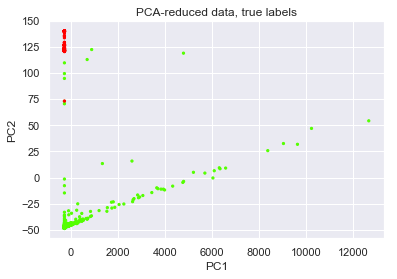

In [27]:
plot_true(X_reduced_all20,binary_df['virus'])

In [10]:
y_pred20, centers20 = k_means_cluster(X_reduced_all20)

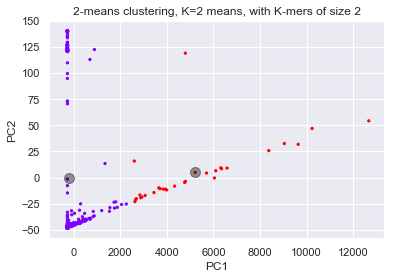

In [120]:
plot_kmeans(X_reduced_all20, y_pred20, centers20,2)

In [6]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


def k_means_elbow(data):
    df = pd.DataFrame(data)

    sse = {}
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, max_iter=100000).fit(df)
        df["curr_clusters"] = kmeans.labels_
        sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of clusters")
    plt.ylabel("SSE")
    plt.show()

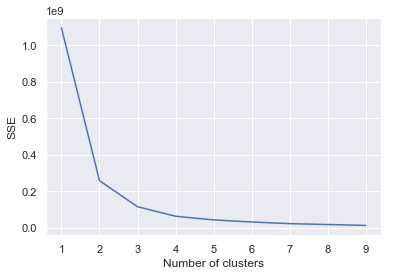

In [122]:
k_means_elbow(X_reduced_all20) #better k available? Looks like 2 is reasonable.

# part 2: Classification (binary)

In [4]:
#part 2: Classification (binary)

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

def corona_classifier(seq_df,k,classes):

    corona_df = seq_df
    corona_df['kmers'] = get_kmers_df(corona_df,k)
    corona_kmer_counts = get_kmer_counts(corona_df, k)

    X = corona_kmer_counts.toarray()
    y = classes

     #.astype('category').cat.codes
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size = 0.20, random_state = 42)

    clf = GaussianNB()
    clf.fit(X_train,y_train)
    
    y_pred = clf.predict(X_test)
    
    
    #plotting confusion matrix for this classifier:
# https://stackoverflow.com/questions/55247669/how-to-plot-confusion-matrices-of-different-types-in-python-with-minimal-code
    
    # Creates a confusion matrix 
    cm = confusion_matrix(y_test, y_pred) 

    # Transform to df for easier plotting
    cm_df = pd.DataFrame(cm)
    plt.figure(figsize=(5.5,4))
    sns.heatmap(cm_df, annot=True, cbar= True, cmap = 'cubehelix')
    plt.title(f'Guassian Naive Bayes, ({k}-mers)')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    return y_test,y_pred,clf


In [18]:
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1

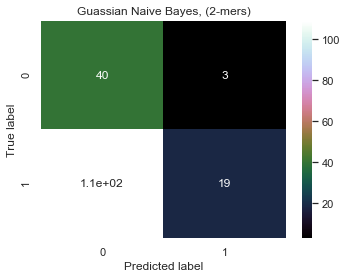

2-mers:
 Accuracy = 0.345 
precision = 0.714 
recall = 0.345 
f1 = 0.294


In [17]:
y_test2, y_pred2,clf2 = corona_classifier(binary_df,2, binary_df['virus'].astype(int))
print('2-mers:\n Accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f' % (get_metrics(y_test2, y_pred2)))

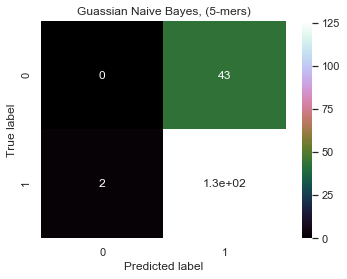

5-mers:
 Accuracy = 0.737 
precision = 0.558 
recall = 0.737 
f1 = 0.635


In [14]:
y_test5, y_pred5,clf5 = corona_classifier(binary_df,5, binary_df['virus'].astype(int))
print('5-mers:\n Accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f' % (get_metrics(y_test5, y_pred5)))

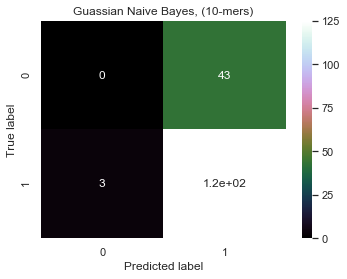

10-mers:
 Accuracy = 0.731 
precision = 0.557 
recall = 0.731 
f1 = 0.632


In [15]:
y_test10, y_pred10,clf10 = corona_classifier(binary_df,10, binary_df['virus'].astype(int))
print('10-mers:\n Accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f' % (get_metrics(y_test10, y_pred10)))

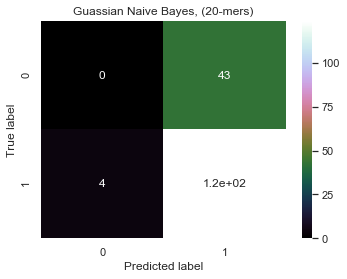

20-mers:
 Accuracy = 0.725 
precision = 0.556 
recall = 0.725 
f1 = 0.629


In [15]:
y_test20, y_pred20,clf20 = corona_classifier(binary_df,20, binary_df['virus'].astype(int))
print('20-mers:\n Accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f' % (get_metrics(y_test20, y_pred20)))

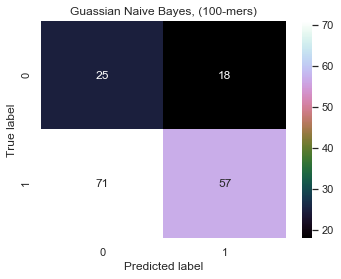

100-mers:
 Accuracy = 0.480 
precision = 0.634 
recall = 0.480 
f1 = 0.511


In [16]:
y_test100, y_pred100,clf100 = corona_classifier(binary_df,100, binary_df['virus'].astype(int)) # classes = location of exposure. host not terribly useful since tester obviously can know host. what is more hidden is locaiton of exposure.)
print('100-mers:\n Accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f' % (get_metrics(y_test100, y_pred100)))